# Tabla de clasificación de defectos — *new methods testing*

Este notebook es una copia “extendida” del flujo de `defect_classification_table_fixed.ipynb`, pero añadiendo **preprocesados más robustos** para intentar que el modelo de Roboflow sea menos sensible a iluminación/reflejos.

### Métodos añadidos
- **Percentile stretch (autocontrast por percentiles)**: comprime highlights y levanta sombras (lo que pedías: “bajar muy brillantes y subir muy oscuros”).
- **Curva S (sigmoid / tone curve)**: similar a “Shadows/Highlights” de edición fotográfica.
- **White balance (gray-world)**: corrige dominantes (amarillo/azul) entre sesiones.
- **CLAHE en luminancia (LAB)**: realza contraste local (defectos pequeños).
- **Retinex (SSR)**: normaliza iluminación (sombras y gradientes).
- **Highlight compression en canal V (HSV)**: baja reflejos especulares sin tocar tanto el resto.
- **Padding a cuadrado + resize**: hace que el encuadre/escala sea más consistente con el dataset de Roboflow.

> Nota: estos métodos **no siempre mejoran** (a veces te alejan de la distribución de entrenamiento). Por eso aquí los probamos de forma sistemática y resumimos por lote.


In [21]:
from __future__ import annotations

from pathlib import Path
import os
import sys
import re
from typing import Any, Dict, List, Optional, Tuple

import numpy as np
import pandas as pd

from PIL import Image, ImageEnhance, ImageOps

# OpenCV (para LAB/HSV/CLAHE/Retinex)
import cv2

# ---------------------------------------------------------------------
# Localiza el root del repo (buscando 'data/')
# ---------------------------------------------------------------------
def find_project_root(start: Path | None = None, marker_dir: str = "data") -> Path:
    start = Path.cwd() if start is None else Path(start).resolve()
    for p in [start, *start.parents]:
        if (p / marker_dir).exists() and (p / marker_dir).is_dir():
            return p
    raise FileNotFoundError(f"No he encontrado '{marker_dir}/' subiendo desde {start}")

PROJECT_ROOT = find_project_root()
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

# ---------------------------------------------------------------------
# Imports del proyecto (usa tus funciones existentes cuando convenga)
# ---------------------------------------------------------------------
try:
    from src.raw_image_treatment import potato_pixels_rgb_img, potato_defect_classification # recorte por detección
except Exception as e:
    raise ImportError(
        "No he podido importar desde src/raw_image_treatment.py.\n"
        "Asegúrate de ejecutar este notebook dentro del repo y que existe src/raw_image_treatment.py.\n"
        f"Error: {e}"
    )

# ---------------------------------------------------------------------
# Roboflow inference SDK (para NO llamar N veces solo por cambiar threshold)
# ---------------------------------------------------------------------
try:
    from inference_sdk import InferenceHTTPClient
except Exception as e:
    raise ImportError(
        "No he podido importar inference_sdk. Instálalo en tu env:\n"
        "  pip install inference-sdk\n"
        f"Error: {e}"
    )


In [15]:
# ------------------------------------------------------------
# Rutas de imágenes (ajusta si tu repo usa otras)
# ------------------------------------------------------------
DIR_DEFINITIVE = PROJECT_ROOT / "data/input/raw/raw_images/definitive"
DIR_TEST = PROJECT_ROOT / "data/input/raw/raw_images/test_1"
DIR_CROPPED_DEF = PROJECT_ROOT / "data/input/processed/cropped_def"

def natural_sort_key(p: Path):
    parts = re.split(r"(\d+)", p.name)
    key = []
    for part in parts:
        if part.isdigit():
            key.append(int(part))
        else:
            key.append(part.lower())
    return key

def list_images(source: str, pattern: str) -> List[Path]:
    if source == "definitive":
        base = DIR_DEFINITIVE
    elif source == "test_1":
        base = DIR_TEST
    elif source == "cropped_def":
        base = DIR_CROPPED_DEF
    else:
        raise ValueError("source debe ser 'definitive', 'test_1' o 'cropped_def'")

    if not base.exists():
        raise FileNotFoundError(f"No existe la carpeta: {base}")

    paths = sorted(base.glob(pattern), key=natural_sort_key)
    return paths

def infer_lot_from_name(name: str) -> Optional[int]:
    """Intenta extraer el lote desde nombres tipo p3_..., p4_..., p5_..., p6_..."""
    m = re.search(r"(?:^|_)p(\d+)_", name)
    if m:
        return int(m.group(1))
    m = re.search(r"^p(\d+)_", name)
    if m:
        return int(m.group(1))
    return None

print("definitive exists:", DIR_DEFINITIVE.exists(), "|", DIR_DEFINITIVE)
print("cropped_def exists:", DIR_CROPPED_DEF.exists(), "|", DIR_CROPPED_DEF)
print("test_1 exists:", DIR_TEST.exists(), "|", DIR_TEST)


definitive exists: True | c:\Users\david\Desktop\Uni\potato-dry-matter-optics-ml\data\input\raw\raw_images\definitive
cropped_def exists: True | c:\Users\david\Desktop\Uni\potato-dry-matter-optics-ml\data\input\processed\cropped_def
test_1 exists: True | c:\Users\david\Desktop\Uni\potato-dry-matter-optics-ml\data\input\raw\raw_images\test_1


In [16]:
# ------------------------------------------------------------
# Utils de conversión
# ------------------------------------------------------------
def to_pil_rgb(img_in: Any) -> Image.Image:
    if isinstance(img_in, Image.Image):
        return img_in.convert("RGB")
    if isinstance(img_in, (str, Path, os.PathLike)):
        return Image.open(str(img_in)).convert("RGB")
    if isinstance(img_in, np.ndarray):
        arr = img_in
        if arr.ndim == 2:
            arr = np.stack([arr, arr, arr], axis=-1)
        if arr.ndim != 3 or arr.shape[2] not in (3, 4):
            raise ValueError(f"numpy array con forma inválida: {arr.shape}")
        if arr.shape[2] == 4:
            arr = arr[:, :, :3]
        if arr.dtype != np.uint8:
            arr = np.clip(arr, 0, 255).astype(np.uint8)
        return Image.fromarray(arr, mode="RGB")
    raise TypeError("img_in debe ser Path/str, PIL.Image o np.ndarray")

def pil_to_bgr_uint8(pil: Image.Image) -> np.ndarray:
    rgb = np.array(pil.convert("RGB"), dtype=np.uint8)
    return cv2.cvtColor(rgb, cv2.COLOR_RGB2BGR)

def bgr_to_pil_rgb(bgr: np.ndarray) -> Image.Image:
    rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
    return Image.fromarray(rgb.astype(np.uint8), mode="RGB")

def pad_to_square(pil: Image.Image, fill=(0,0,0)) -> Image.Image:
    w, h = pil.size
    m = max(w, h)
    out = Image.new("RGB", (m, m), fill)
    out.paste(pil, ((m - w)//2, (m - h)//2))
    return out

def resize_max_side(pil: Image.Image, max_side: int = 640) -> Image.Image:
    w, h = pil.size
    s = max(w, h)
    if s <= max_side:
        return pil
    scale = max_side / s
    new_w, new_h = max(1, int(w*scale)), max(1, int(h*scale))
    resample = Image.Resampling.LANCZOS if hasattr(Image, "Resampling") else Image.LANCZOS
    return pil.resize((new_w, new_h), resample=resample)


In [17]:
# ------------------------------------------------------------
# Preprocesados "nuevos"
# ------------------------------------------------------------
def percentile_stretch(pil: Image.Image, p_low: float = 1.0, p_high: float = 99.0) -> Image.Image:
    """Autocontrast por percentiles en luminancia (LAB-L)."""
    bgr = pil_to_bgr_uint8(pil)
    lab = cv2.cvtColor(bgr, cv2.COLOR_BGR2LAB)
    L, a, b = cv2.split(lab)
    lo = np.percentile(L, p_low)
    hi = np.percentile(L, p_high)
    if hi <= lo + 1e-6:
        return pil
    L2 = np.clip((L.astype(np.float32) - lo) * (255.0 / (hi - lo)), 0, 255).astype(np.uint8)
    lab2 = cv2.merge([L2, a, b])
    return bgr_to_pil_rgb(cv2.cvtColor(lab2, cv2.COLOR_LAB2BGR))

def sigmoid_tone_curve(pil: Image.Image, k: float = 6.0, mid: float = 0.5) -> Image.Image:
    """Curva S (sigmoid) aplicada a luminancia (LAB-L)."""
    bgr = pil_to_bgr_uint8(pil)
    lab = cv2.cvtColor(bgr, cv2.COLOR_BGR2LAB)
    L, a, b = cv2.split(lab)
    x = (L.astype(np.float32) / 255.0)
    y = 1.0 / (1.0 + np.exp(-k * (x - mid)))
    # re-normaliza a [0,1]
    y = (y - y.min()) / (y.max() - y.min() + 1e-8)
    L2 = np.clip(y * 255.0, 0, 255).astype(np.uint8)
    lab2 = cv2.merge([L2, a, b])
    return bgr_to_pil_rgb(cv2.cvtColor(lab2, cv2.COLOR_LAB2BGR))

def gray_world_white_balance(pil: Image.Image) -> Image.Image:
    """White balance simple: escala cada canal para igualar medias (gray-world)."""
    rgb = np.array(pil.convert("RGB"), dtype=np.float32)
    means = rgb.reshape(-1, 3).mean(axis=0)
    target = means.mean()
    scale = target / (means + 1e-8)
    out = np.clip(rgb * scale[None, None, :], 0, 255).astype(np.uint8)
    return Image.fromarray(out, mode="RGB")

def clahe_luminance(pil: Image.Image, clip_limit: float = 2.0, tile_grid_size: int = 8) -> Image.Image:
    bgr = pil_to_bgr_uint8(pil)
    lab = cv2.cvtColor(bgr, cv2.COLOR_BGR2LAB)
    L, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=float(clip_limit), tileGridSize=(int(tile_grid_size), int(tile_grid_size)))
    L2 = clahe.apply(L)
    lab2 = cv2.merge([L2, a, b])
    return bgr_to_pil_rgb(cv2.cvtColor(lab2, cv2.COLOR_LAB2BGR))

def retinex_ssr(pil: Image.Image, sigma: float = 50.0) -> Image.Image:
    """Single-Scale Retinex en luminancia (LAB-L) para corregir iluminación."""
    bgr = pil_to_bgr_uint8(pil)
    lab = cv2.cvtColor(bgr, cv2.COLOR_BGR2LAB)
    L, a, b = cv2.split(lab)
    Lf = L.astype(np.float32) + 1.0
    blur = cv2.GaussianBlur(Lf, (0, 0), sigmaX=float(sigma), sigmaY=float(sigma))
    r = np.log(Lf) - np.log(blur + 1e-6)
    r = (r - r.min()) / (r.max() - r.min() + 1e-8)
    L2 = np.clip(r * 255.0, 0, 255).astype(np.uint8)
    lab2 = cv2.merge([L2, a, b])
    return bgr_to_pil_rgb(cv2.cvtColor(lab2, cv2.COLOR_LAB2BGR))

def highlight_compress_hsv(pil: Image.Image, knee: float = 0.80, strength: float = 0.65) -> Image.Image:
    """Comprime highlights del canal V (HSV) con 'soft knee'."""
    bgr = pil_to_bgr_uint8(pil)
    hsv = cv2.cvtColor(bgr, cv2.COLOR_BGR2HSV).astype(np.float32)
    H, S, V = cv2.split(hsv)
    v = V / 255.0
    # soft-knee: para v>knee, aplana
    t = np.clip((v - knee) / (1.0 - knee + 1e-8), 0, 1)
    v2 = v - strength * (t**2) * (v - knee)
    V2 = np.clip(v2 * 255.0, 0, 255).astype(np.uint8)
    hsv2 = cv2.merge([H.astype(np.uint8), S.astype(np.uint8), V2])
    return bgr_to_pil_rgb(cv2.cvtColor(hsv2, cv2.COLOR_HSV2BGR))

# ------------------------------------------------------------
# Wrapper: define métodos y parámetros
# ------------------------------------------------------------
def apply_preprocess(pil: Image.Image, method: str) -> Image.Image:
    pil = pil.convert("RGB")

    if method == "none":
        return pil

    if method == "wb":
        return gray_world_white_balance(pil)

    if method == "pct_stretch":
        return percentile_stretch(pil, p_low=1.0, p_high=99.0)

    if method == "sigmoid":
        return sigmoid_tone_curve(pil, k=6.0, mid=0.5)

    if method == "clahe":
        return clahe_luminance(pil, clip_limit=2.0, tile_grid_size=8)

    if method == "retinex":
        return retinex_ssr(pil, sigma=50.0)

    if method == "hl_comp":
        return highlight_compress_hsv(pil, knee=0.80, strength=0.65)

    if method == "wb+clahe":
        return clahe_luminance(gray_world_white_balance(pil), clip_limit=2.0, tile_grid_size=8)

    if method == "retinex+clahe":
        return clahe_luminance(retinex_ssr(pil, sigma=50.0), clip_limit=2.0, tile_grid_size=8)

    if method == "square_640":
        return resize_max_side(pad_to_square(pil, fill=(0,0,0)), max_side=640)

    raise ValueError(f"Método no soportado: {method}")

METHODS = [
    "none",
    "square_640",
    "pct_stretch",
    "sigmoid",
    "hl_comp",
    "wb",
    "clahe",
    "retinex",
    "wb+clahe",
    "retinex+clahe",
]


In [5]:
# ------------------------------------------------------------
# Roboflow: inferencia 1 vez y luego thresholding local
# ------------------------------------------------------------
ROBOFLOW_MODEL_ID = "potato-detection-3et6q/11"
ROBOFLOW_API_URL = "https://serverless.roboflow.com"
ROBOFLOW_API_KEY_ENV = "ROBOFLOW_API_KEY"  # debe existir en tu entorno

def roboflow_infer(pil_img: Image.Image) -> Dict[str, Any]:
    api_key = os.environ.get(ROBOFLOW_API_KEY_ENV)
    if not api_key:
        raise RuntimeError(f"Falta la variable de entorno {ROBOFLOW_API_KEY_ENV}")
    client = InferenceHTTPClient(api_url=ROBOFLOW_API_URL, api_key=api_key)
    return client.infer(pil_img, model_id=ROBOFLOW_MODEL_ID)

def pick_best_prediction(result: Dict[str, Any], thr: float) -> Optional[Dict[str, Any]]:
    preds = result.get("predictions", []) if isinstance(result, dict) else []
    if not preds:
        return None
    best = max(preds, key=lambda p: float(p.get("confidence", 0.0)))
    return best if float(best.get("confidence", 0.0)) >= thr else None

def bbox_from_pred(pred: Dict[str, Any]) -> Optional[Tuple[float, float, float, float]]:
    if all(k in pred for k in ("x", "y", "width", "height")):
        x = float(pred["x"])
        y = float(pred["y"])
        w = float(pred["width"])
        h = float(pred["height"])
        return (x - w/2.0, y - h/2.0, x + w/2.0, y + h/2.0)
    if all(k in pred for k in ("x1", "y1", "x2", "y2")):
        return (float(pred["x1"]), float(pred["y1"]), float(pred["x2"]), float(pred["y2"]))
    return None

def classify_from_result(result: Dict[str, Any], thr: float) -> Tuple[str, float]:
    best = pick_best_prediction(result, thr)
    if best is None:
        return "Unable to classify", 0.0
    return str(best.get("class", "unknown")), float(best.get("confidence", 0.0))


In [6]:
# ------------------------------------------------------------
# Runner: recorte opcional + preprocs + inferencia + thresholds
# ------------------------------------------------------------
def run_defect_table_new_methods(
    *,
    source: str,
    pattern: str = "*.png",
    max_images: int | None = None,
    do_cut: bool = False,
    cut_margin: int = 35,
    cut_min_conf: float = 0.01,
    methods: List[str] = METHODS,
    thresholds: List[float] = [0.20, 0.30, 0.40, 0.50],
) -> pd.DataFrame:
    paths = list_images(source, pattern)
    if max_images is not None:
        paths = paths[: int(max_images)]

    rows: List[Dict[str, Any]] = []

    # Cache para evitar recalcular / reinferir
    infer_cache: Dict[Tuple[str, str], Dict[str, Any]] = {}  # (filename, method) -> result

    for i, p in enumerate(paths, start=1):
        lot = infer_lot_from_name(p.name)

        # carga base
        base_pil = Image.open(str(p)).convert("RGB")

        # cut opcional (si la imagen NO está ya recortada)
        pil_for_pre = base_pil
        if do_cut and source != "cropped_def":
            cropped, _vis = potato_pixels_rgb_img(pil_for_pre, margin=cut_margin, min_conf=cut_min_conf)
            if cropped is None:
                for thr in thresholds:
                    rows.append({
                        "image": p.name,
                        "lot": lot,
                        "source": source,
                        "method": None,
                        "thr": float(thr),
                        "pred_class": None,
                        "confidence": 0.0,
                        "status": "no_potato_detected",
                    })
                continue
            pil_for_pre = cropped.convert("RGB")

        for method in methods:
            try:
                proc = apply_preprocess(pil_for_pre, method)

                cache_key = (p.name, method)
                if cache_key not in infer_cache:
                    infer_cache[cache_key] = roboflow_infer(proc)

                result = infer_cache[cache_key]

                for thr in thresholds:
                    cls, conf = classify_from_result(result, float(thr))
                    rows.append({
                        "image": p.name,
                        "lot": lot,
                        "source": source,
                        "method": method,
                        "thr": float(thr),
                        "pred_class": cls,
                        "confidence": float(conf),
                        "status": "ok" if cls != "Unable to classify" else "no_pred_above_thr",
                    })

            except Exception as e:
                for thr in thresholds:
                    rows.append({
                        "image": p.name,
                        "lot": lot,
                        "source": source,
                        "method": method,
                        "thr": float(thr),
                        "pred_class": None,
                        "confidence": None,
                        "status": "error",
                        "error": repr(e),
                    })

        if i % 10 == 0:
            print(f"Procesadas {i}/{len(paths)}")

    df = pd.DataFrame(rows)

    # limpieza tipos
    if "confidence" in df.columns:
        df["confidence"] = pd.to_numeric(df["confidence"], errors="coerce")

    return df



In [7]:
# ==============================
# PARÁMETROS (edita aquí)
# ==============================
SOURCE = "definitive"    # 'definitive', 'cropped_def', 'test_1'
PATTERN = "p3_*.png"     # ej: "p3_*.png" o "*.png"
MAX_IMAGES = 50           # None para todas

# Cut (solo si SOURCE != 'cropped_def')
DO_CUT = False
CUT_MARGIN = 35
CUT_MIN_CONF = 0.01

# Métodos y thresholds a probar (puedes reducir para ir rápido)
METHODS_TO_TEST = METHODS
THRESHOLDS = [0.20, 0.30, 0.40, 0.50, 0.60]

df = run_defect_table_new_methods(
    source=SOURCE,
    pattern=PATTERN,
    max_images=MAX_IMAGES,
    do_cut=DO_CUT,
    cut_margin=CUT_MARGIN,
    cut_min_conf=CUT_MIN_CONF,
    methods=METHODS_TO_TEST,
    thresholds=THRESHOLDS,
)

display(df.head(20))
print("Rows:", len(df))


'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)


Procesadas 10/30
Procesadas 20/30
Procesadas 30/30


,image,lot,source,method,thr,pred_class,confidence,status
0,p3_1.png,3,definitive,none,0.2,Diseased-fungal potato,0.584635,ok
1,p3_1.png,3,definitive,none,0.3,Diseased-fungal potato,0.584635,ok
2,p3_1.png,3,definitive,none,0.4,Diseased-fungal potato,0.584635,ok
3,p3_1.png,3,definitive,none,0.5,Diseased-fungal potato,0.584635,ok
4,p3_1.png,3,definitive,none,0.6,Unable to classify,0.000000,no_pred_above_thr
5,p3_1.png,3,definitive,square_640,0.2,Damaged potato,0.568753,ok
6,p3_1.png,3,definitive,square_640,0.3,Damaged potato,0.568753,ok
7,p3_1.png,3,definitive,square_640,0.4,Damaged potato,0.568753,ok
8,p3_1.png,3,definitive,square_640,0.5,Damaged potato,0.568753,ok
9,p3_1.png,3,definitive,square_640,0.6,Unable to classify,0.000000,no_pred_above_thr


Rows: 1500


## Resumen útil: clases únicas y mapping “buena vs defectuosa”

1) Mira qué clases devuelve el modelo con **tus** imágenes.  
2) Decide qué clases son “defectuosa” (normalmente todo lo que no sea `Potato`).

> Si el modelo devuelve clases que no esperabas, lo verás aquí enseguida.


In [8]:
# Clases detectadas (con independencia de thr, usando la predicción >= 0.20 por defecto)
thr_for_list = float(min(THRESHOLDS))

df_thr = df[df["thr"] == thr_for_list].copy()
classes = (
    df_thr["pred_class"]
    .fillna("<None>")
    .value_counts(dropna=False)
    .to_frame("count")
)
display(classes)

# Define mapping (ajusta según la salida anterior)
GOOD_CLASSES = {"Potato"}
# Por defecto: todo lo que NO sea 'Potato' y NO sea 'Unable to classify' lo consideramos defecto.
def is_defective(pred_class: str | None) -> Optional[bool]:
    if pred_class is None:
        return None
    if pred_class == "Unable to classify":
        return False  # lo tratamos como 'no defecto' (o 'desconocido' -> cámbialo si prefieres)
    if pred_class in GOOD_CLASSES:
        return False
    return True

df["pred_defective"] = df["pred_class"].apply(is_defective)

# Ground truth aproximado por lote (según tu hipótesis)
GOOD_LOTS = {3, 4}
DEFECT_LOTS = {5, 6}

def expected_defective(lot: Optional[int]) -> Optional[bool]:
    if lot is None:
        return None
    if lot in GOOD_LOTS:
        return False
    if lot in DEFECT_LOTS:
        return True
    return None

df["expected_defective"] = df["lot"].apply(expected_defective)

display(df.head(10))


,count
pred_class,
Diseased-fungal potato,179
Damaged potato,78
Potato,23
Unable to classify,17
Defected potato,2
Sprouted potato,1


,image,lot,source,method,thr,pred_class,confidence,status,pred_defective,expected_defective
0,p3_1.png,3,definitive,none,0.2,Diseased-fungal potato,0.584635,ok,True,False
1,p3_1.png,3,definitive,none,0.3,Diseased-fungal potato,0.584635,ok,True,False
2,p3_1.png,3,definitive,none,0.4,Diseased-fungal potato,0.584635,ok,True,False
3,p3_1.png,3,definitive,none,0.5,Diseased-fungal potato,0.584635,ok,True,False
4,p3_1.png,3,definitive,none,0.6,Unable to classify,0.000000,no_pred_above_thr,False,False
5,p3_1.png,3,definitive,square_640,0.2,Damaged potato,0.568753,ok,True,False
6,p3_1.png,3,definitive,square_640,0.3,Damaged potato,0.568753,ok,True,False
7,p3_1.png,3,definitive,square_640,0.4,Damaged potato,0.568753,ok,True,False
8,p3_1.png,3,definitive,square_640,0.5,Damaged potato,0.568753,ok,True,False
9,p3_1.png,3,definitive,square_640,0.6,Unable to classify,0.000000,no_pred_above_thr,False,False


In [9]:
# ------------------------------------------------------------
# Métricas por método/threshold y resumen por lote
# ------------------------------------------------------------
def compute_metrics(sub: pd.DataFrame) -> Dict[str, float]:
    # filtra donde hay etiqueta esperada
    s = sub.dropna(subset=["expected_defective", "pred_defective"]).copy()
    if len(s) == 0:
        return {"n": 0}
    y = s["expected_defective"].astype(bool).to_numpy()
    p = s["pred_defective"].astype(bool).to_numpy()

    tp = int(np.sum((p == 1) & (y == 1)))
    tn = int(np.sum((p == 0) & (y == 0)))
    fp = int(np.sum((p == 1) & (y == 0)))
    fn = int(np.sum((p == 0) & (y == 1)))

    acc = (tp + tn) / max(1, (tp + tn + fp + fn))
    tpr = tp / max(1, (tp + fn))  # recall defectuosas
    fpr = fp / max(1, (fp + tn))  # false alarm en buenas
    return {
        "n": int(tp + tn + fp + fn),
        "acc": float(acc),
        "tpr_defective_recall": float(tpr),
        "fpr_good_false_alarm": float(fpr),
        "tp": tp, "tn": tn, "fp": fp, "fn": fn,
    }

# tabla métricas
metrics_rows = []
for (method, thr), sub in df.groupby(["method", "thr"], dropna=False):
    m = compute_metrics(sub)
    m.update({"method": method, "thr": thr})
    metrics_rows.append(m)

metrics = pd.DataFrame(metrics_rows).sort_values(["acc", "tpr_defective_recall"], ascending=False)
display(metrics.head(30))

# resumen por lote (proporción defectuosa predicha)
lot_summary = (
    df.dropna(subset=["lot"])
      .groupby(["lot", "method", "thr"], as_index=False)["pred_defective"]
      .mean()
      .rename(columns={"pred_defective": "pred_defective_rate"})
      .sort_values(["lot", "pred_defective_rate"], ascending=[True, False])
)
display(lot_summary.head(40))


,n,acc,tpr_defective_recall,fpr_good_false_alarm,tp,tn,fp,fn,method,thr
34,30,0.966667,0.0,0.033333,0,29,1,0,sigmoid,0.6
33,30,0.933333,0.0,0.066667,0,28,2,0,sigmoid,0.5
30,30,0.866667,0.0,0.133333,0,26,4,0,sigmoid,0.2
31,30,0.866667,0.0,0.133333,0,26,4,0,sigmoid,0.3
32,30,0.866667,0.0,0.133333,0,26,4,0,sigmoid,0.4
24,30,0.700000,0.0,0.300000,0,21,9,0,retinex,0.6
19,30,0.533333,0.0,0.466667,0,16,14,0,pct_stretch,0.6
39,30,0.500000,0.0,0.500000,0,15,15,0,square_640,0.6
14,30,0.400000,0.0,0.600000,0,12,18,0,none,0.6
23,30,0.366667,0.0,0.633333,0,11,19,0,retinex,0.5


,lot,method,thr,pred_defective_rate
0,3,clahe,0.2,1.000000
1,3,clahe,0.3,1.000000
2,3,clahe,0.4,1.000000
3,3,clahe,0.5,1.000000
25,3,retinex+clahe,0.2,1.000000
26,3,retinex+clahe,0.3,1.000000
27,3,retinex+clahe,0.4,1.000000
5,3,hl_comp,0.2,0.966667
6,3,hl_comp,0.3,0.966667
7,3,hl_comp,0.4,0.966667


'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)


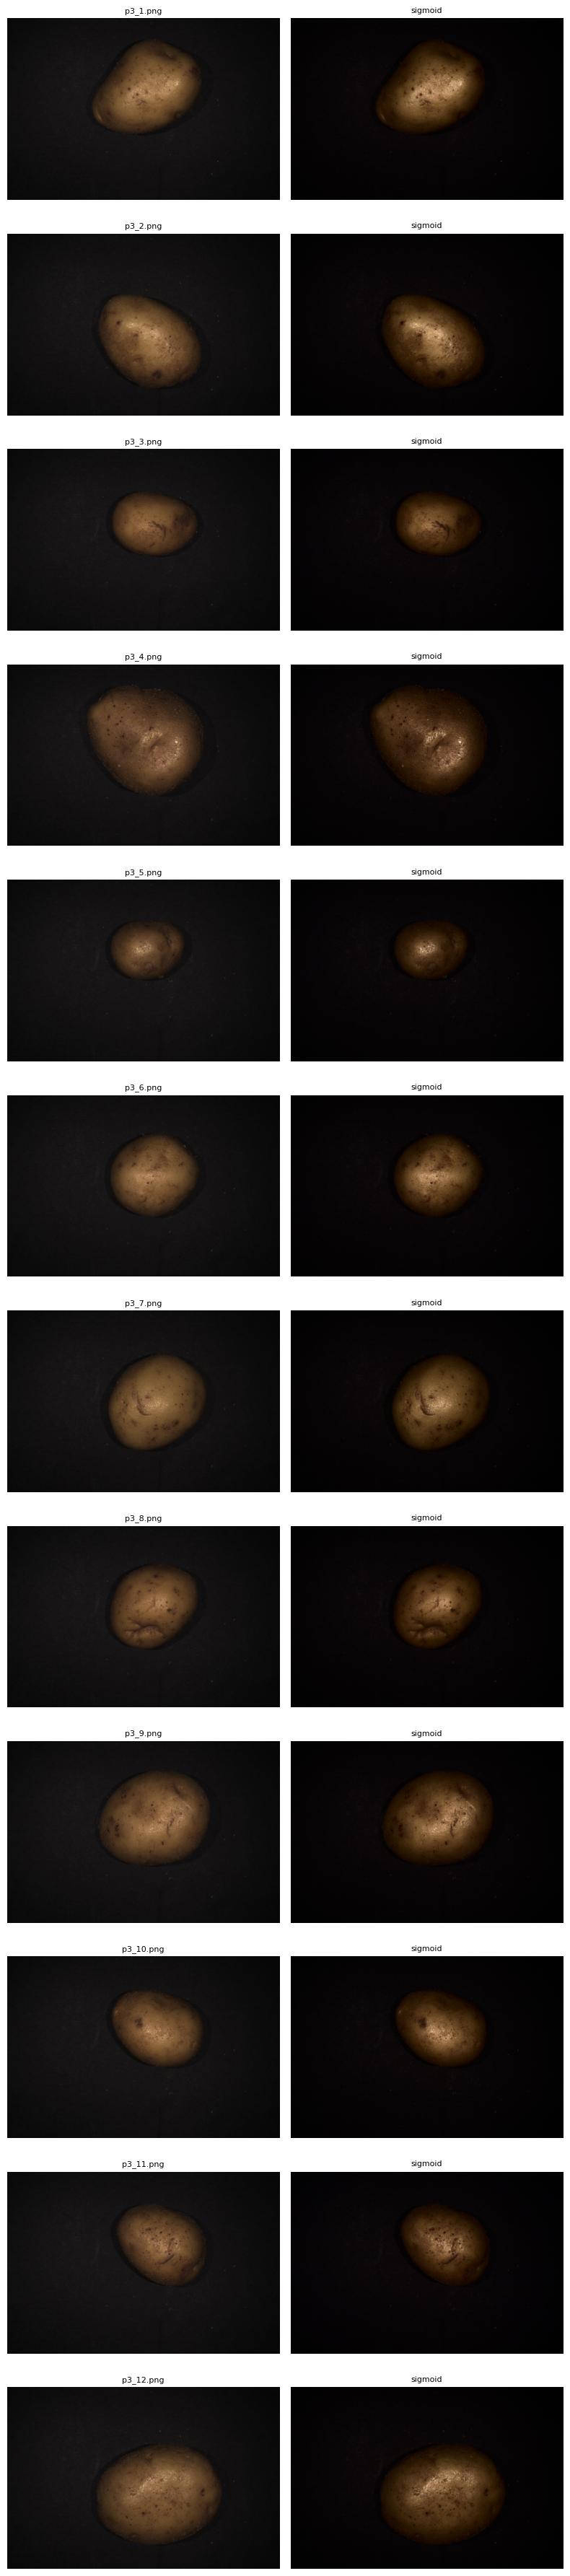

In [11]:
# ------------------------------------------------------------
# Visual debug: muestra original vs preprocesado (elige método)
# ------------------------------------------------------------
import matplotlib.pyplot as plt

SHOW_METHOD = "sigmoid"   # prueba: 'pct_stretch', 'sigmoid', 'hl_comp', 'retinex+clahe', etc.
N_SHOW = 12

paths = list_images(SOURCE, PATTERN)
if MAX_IMAGES is not None:
    paths = paths[: int(MAX_IMAGES)]
paths = paths[:N_SHOW]

fig, axes = plt.subplots(len(paths), 2, figsize=(8, 3*len(paths)))
if len(paths) == 1:
    axes = np.array([axes])

for i, p in enumerate(paths):
    base = Image.open(str(p)).convert("RGB")
    proc = apply_preprocess(base, SHOW_METHOD)

    axes[i, 0].imshow(base)
    axes[i, 0].axis("off")
    axes[i, 0].set_title(p.name, fontsize=8)

    axes[i, 1].imshow(proc)
    axes[i, 1].axis("off")
    axes[i, 1].set_title(SHOW_METHOD, fontsize=8)

plt.tight_layout()
plt.show()


In [25]:
# === p3: imprimir clasificación por imagen (sigmoid, thr=0.2) =========

from pathlib import Path
from PIL import Image

P3_DIR = (PROJECT_ROOT / "data" / "input" / "raw" / "raw_images" / "definitive")  # ajusta si tu ruta es otra
THR = 0.20

paths = sorted(list(P3_DIR.glob("p4_*.png")) + list(P3_DIR.glob("*.jpg")) + list(P3_DIR.glob("*.jpeg")))
print(f"Encontradas {len(paths)} imágenes en: {P3_DIR}\n")

for p in paths:
    img = Image.open(p).convert("RGB")

    # Preproceso: sigmoid (usa tu función del notebook new_methods)
    img_proc = apply_preprocess(img, method="sigmoid")

    defect, conf, _ = potato_defect_classification(img_proc, confidence_threshold=THR)

    print(f"{p.name:35s} -> {defect:22s}  conf={conf:.3f}")


Encontradas 72 imágenes en: c:\Users\david\Desktop\Uni\potato-dry-matter-optics-ml\data\input\raw\raw_images\definitive



'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)


p4_1.png                            -> Potato                  conf=0.830
p4_10.png                           -> Potato                  conf=0.681
p4_11.png                           -> Potato                  conf=0.833
p4_12.png                           -> Potato                  conf=0.857
p4_13.png                           -> Potato                  conf=0.408
p4_14.png                           -> Potato                  conf=0.824
p4_15.png                           -> Potato                  conf=0.453
p4_16.png                           -> Potato                  conf=0.552
p4_17.png                           -> Potato                  conf=0.472
p4_18.png                           -> Diseased-fungal potato  conf=0.652
p4_19.png                           -> Potato                  conf=0.438
p4_2.png                            -> Potato                  conf=0.845
p4_20.png                           -> Potato                  conf=0.741
p4_21.png                           ->